In [1]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics
from sklearn.metrics import roc_auc_score

# import matplotlib.pyplot as plt

from sklearn.externals import joblib

In [26]:
import pickle

In [2]:
import matplotlib.pyplot as plt

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [4]:
from sklearn.metrics import accuracy_score

In [5]:
import pandas as pd
import numpy as np

### Model trainig without hyper-parameter tuning

In [6]:
def train_model(train, valid, test, features,target):
    cv_folds = 5
    early_stopping_rounds = 50
    
    ### Forming copy of input datasets
    train_c, valid_c, test_c = train.copy(), valid.copy(), test.copy()
#     out_path = params['out_path']
#     predictors, target = list(params['predictors']), params['target']
    predictors, target = features, target
#     alg = XGBClassifier(
#                 learning_rate =params['learning_rate'],
#                 n_estimators=params['n_estimators'],
#                 max_depth=params['max_depth'],
#                 min_child_weight=params['min_child_weight'],
#                 gamma=params['gamma'],
#                 subsample=params['subsample'],
#                 colsample_bytree=params['colsample_bytree'],
#                 objective= 'binary:logistic',
#                 scale_pos_weight=params['scale_pos_weight'],
#                 seed=27)

    alg = XGBClassifier( colsample_bytree=0.8, gamma=0, learning_rate=0.1,
    max_depth=5, min_child_weight=1, n_estimators=5000, objective='binary:logistic',
    reg_alpha=0, reg_lambda=0, scale_pos_weight=(len(train) -train[df_target].sum())/train[df_target].sum(),
    seed=7, silent=True, subsample=0.8,n_jobs=5)
    
    eval_set = [(valid_c[predictors],valid_c[target])]
    alg.fit(train_c[predictors], train_c[target],eval_metric='auc', early_stopping_rounds=early_stopping_rounds, eval_set = eval_set, verbose = True)     
    
    valid_c.loc[:,'prob'] = alg.predict_proba(valid_c[predictors])[:,1]
    test_c.loc[:,'prob'] = alg.predict_proba(test_c[predictors])[:,1]
    
    valid_auc = roc_auc_score(np.array(valid_c.loc[:,target]), np.array(valid_c.loc[:,'prob']))
    test_auc = roc_auc_score(np.array(test_c.loc[:,target]), np.array(test_c.loc[:,'prob']))
    loss = 1 - valid_auc
    
#     if out_path != None:
#         f = open(os.path.join(out_path, "hyperopt_logs.txt"), "a+")
#         f.write("Valid AUC: {} and Test AUC: {}, loss: {}".format(valid_auc,test_auc,loss))
#         f.close()
    
    print ("Valid AUC: {} and Test AUC: {}, Loss: {}".format(valid_auc, test_auc, loss))
    return alg

In [6]:
## Model developed to be used in for loop without print statement

def model_fit_hyperopt(params):
    
#     attempt_count += 1

    ### Asssigning default parameters
#     useTrainCV = False
    cv_folds = 5
    early_stopping_rounds = 50
    
    ### Forming copy of input datasets
    train_c, valid_c, test_c = train.copy(), valid.copy(), test.copy()
#     out_path = params['out_path']
    predictors, target = list(params['predictors']), params['target']
    
    alg = XGBClassifier(
                learning_rate =params['learning_rate'],
                n_estimators=params['n_estimators'],
                max_depth=params['max_depth'],
                min_child_weight=params['min_child_weight'],
                gamma=params['gamma'],
                subsample=params['subsample'],
                colsample_bytree=params['colsample_bytree'],
                objective= 'binary:logistic',
                scale_pos_weight=params['scale_pos_weight'],
                seed=27)

#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(train_c[predictors].values, label=train_c[target].values)
#         xgtest = xgb.DMatrix(valid_c[predictors].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics = 'auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False, seed=27)
#         ne_new = n_estimators=cvresult.shape[0]
#         alg.set_params(n_estimators=cvresult.shape[0])
        
    #Fit the algorithm on the data
    eval_set = [(valid_c[predictors],valid_c[target])]
    alg.fit(train_c[predictors], train_c[target],eval_metric='auc', early_stopping_rounds=early_stopping_rounds, eval_set = eval_set, verbose = True)     
    
    valid_c.loc[:,'prob'] = alg.predict_proba(valid_c[predictors])[:,1]
    test_c.loc[:,'prob'] = alg.predict_proba(test_c[predictors])[:,1]
    
    valid_auc = roc_auc_score(np.array(valid_c.loc[:,target]), np.array(valid_c.loc[:,'prob']))
    test_auc = roc_auc_score(np.array(test_c.loc[:,target]), np.array(test_c.loc[:,'prob']))
    loss = 1 - valid_auc
    
#     if out_path != None:
#         f = open(os.path.join(out_path, "hyperopt_logs.txt"), "a+")
#         f.write("Valid AUC: {} and Test AUC: {}, loss: {}".format(valid_auc,test_auc,loss))
#         f.close()
    
    print ("Valid AUC: {} and Test AUC: {}, Loss: {}".format(valid_auc, test_auc, loss))
    
    return {'loss': loss, 'status': STATUS_OK, 'params': params, 'model':alg}

In [7]:
def get_best_model_xgb(space, train, valid, test):
    
#     f = open(os.path.join(out_path, "hyperopt_logs.txt"), "w+")
#     f.close()

    trials=Trials()
    best = fmin(model_fit_hyperopt, space, algo=tpe.suggest, max_evals=75, trials=trials)
    
    return trials.best_trial['result']['model'], trials.best_trial['result']

In [8]:
# def train_validate_test_split(df, train_percent=.60, validate_percent=.20, seed=42):
#     np.random.seed(seed)
#     perm = np.random.permutation(df.index)
#     m = len(df.index)
#     train_end = int(train_percent * m)
#     validate_end = int(validate_percent * m) + train_end
#     train = df.iloc[perm[:train_end]]
#     validate = df.iloc[perm[train_end:validate_end]]
#     test = df.iloc[perm[validate_end:]]
#     return train, validate, test

In [7]:
def data(df,target):
    processed_df = pd.get_dummies(df,sparse=True)
    df_features = list(set(processed_df.columns) - set([target]))
#     train, valid, test = train_validate_test_split(processed_df)
    train = processed_df.ix[train_o.index]
    valid = processed_df.ix[valid_o.index]
    test = processed_df.ix[test_o.index]
    return train, valid, test, df_features, target

In [8]:
train_o = pd.read_csv('../data/train_insurance.csv',index_col = 0)
valid_o = pd.read_csv('../data/valid_insurance.csv',index_col = 0)
test_o = pd.read_csv('../data/test_insurance.csv',index_col = 0)

In [9]:
all_data = pd.concat([train_o,valid_o,test_o])

In [10]:
all_data.drop(['StartedFlag','EstimateTotal'],axis=1,inplace=True)

In [11]:
train, valid, test, df_features, df_target = data(all_data,target='NewEstimateTotal')

# space = {'learning_rate': hp.choice('learning_rate',[0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]),
#                      'n_estimators': 5000,
#                      'min_child_weight': hp.choice('min_child_weight', [0,1,2,3,4,5,6,7]),
#                      'max_depth': hp.choice('max_depth', [3,4,5,6,7,8,9,10]),
#                      'gamma': hp.choice('gamma', [0,1,5,10]),
#                      'subsample': hp.choice('subsample',np.arange(0.4,1.05,0.1)),
#                      'colsample_bytree': hp.choice('colsample_bytree',np.arange(0.5,1.05,0.1)),
#                      'scale_pos_weight': (len(train) -train[df_target].sum())/train[df_target].sum(),
#                      'predictors': df_features,
#                      'target': df_target
#         }

# best_first_trained, first_trials = get_best_model_xgb(space, train, valid, test)

/home/ambuj/izenda_fullcycle/izenda_insurance_data/insurance_env/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/ambuj/izenda_fullcycle/izenda_insurance_data/insurance_env/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/ambuj/izenda_fullcycle/izenda_insurance_data/insurance_env/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stabl

In [12]:
model = train_model(train.head(100000), valid.head(20000), test, df_features, df_target)

[0]	validation_0-auc:0.83391
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.834514
[2]	validation_0-auc:0.837311
[3]	validation_0-auc:0.837657
[4]	validation_0-auc:0.838016
[5]	validation_0-auc:0.838489
[6]	validation_0-auc:0.838892
[7]	validation_0-auc:0.840851
[8]	validation_0-auc:0.841149
[9]	validation_0-auc:0.841388
[10]	validation_0-auc:0.842388
[11]	validation_0-auc:0.84296
[12]	validation_0-auc:0.843388
[13]	validation_0-auc:0.843733
[14]	validation_0-auc:0.844298
[15]	validation_0-auc:0.844845
[16]	validation_0-auc:0.845173
[17]	validation_0-auc:0.84563
[18]	validation_0-auc:0.845785
[19]	validation_0-auc:0.846099
[20]	validation_0-auc:0.846323
[21]	validation_0-auc:0.846587
[22]	validation_0-auc:0.846967
[23]	validation_0-auc:0.847276
[24]	validation_0-auc:0.847661
[25]	validation_0-auc:0.847999
[26]	validation_0-auc:0.848357
[27]	validation_0-auc:0.84854
[28]	validation_0-auc:0.848728
[29]	validation_0-auc:0.849023
[30]	validation_0-au

[259]	validation_0-auc:0.876005
[260]	validation_0-auc:0.876042
[261]	validation_0-auc:0.876107
[262]	validation_0-auc:0.87613
[263]	validation_0-auc:0.876326
[264]	validation_0-auc:0.876373
[265]	validation_0-auc:0.876405
[266]	validation_0-auc:0.876469
[267]	validation_0-auc:0.876583
[268]	validation_0-auc:0.876627
[269]	validation_0-auc:0.876652
[270]	validation_0-auc:0.876731
[271]	validation_0-auc:0.87674
[272]	validation_0-auc:0.876821
[273]	validation_0-auc:0.876878
[274]	validation_0-auc:0.876911
[275]	validation_0-auc:0.87694
[276]	validation_0-auc:0.876966
[277]	validation_0-auc:0.877022
[278]	validation_0-auc:0.877076
[279]	validation_0-auc:0.877098
[280]	validation_0-auc:0.877147
[281]	validation_0-auc:0.877178
[282]	validation_0-auc:0.877205
[283]	validation_0-auc:0.877252
[284]	validation_0-auc:0.87731
[285]	validation_0-auc:0.877367
[286]	validation_0-auc:0.877374
[287]	validation_0-auc:0.877411
[288]	validation_0-auc:0.877494
[289]	validation_0-auc:0.87751
[290]	validat

[516]	validation_0-auc:0.884689
[517]	validation_0-auc:0.884695
[518]	validation_0-auc:0.884725
[519]	validation_0-auc:0.884824
[520]	validation_0-auc:0.884898
[521]	validation_0-auc:0.884921
[522]	validation_0-auc:0.884893
[523]	validation_0-auc:0.88489
[524]	validation_0-auc:0.884885
[525]	validation_0-auc:0.884892
[526]	validation_0-auc:0.884912
[527]	validation_0-auc:0.884905
[528]	validation_0-auc:0.884925
[529]	validation_0-auc:0.884933
[530]	validation_0-auc:0.884979
[531]	validation_0-auc:0.885013
[532]	validation_0-auc:0.885033
[533]	validation_0-auc:0.885048
[534]	validation_0-auc:0.885066
[535]	validation_0-auc:0.885091
[536]	validation_0-auc:0.8851
[537]	validation_0-auc:0.88512
[538]	validation_0-auc:0.885136
[539]	validation_0-auc:0.885153
[540]	validation_0-auc:0.885172
[541]	validation_0-auc:0.885191
[542]	validation_0-auc:0.885194
[543]	validation_0-auc:0.885217
[544]	validation_0-auc:0.885202
[545]	validation_0-auc:0.885226
[546]	validation_0-auc:0.885237
[547]	valida

[773]	validation_0-auc:0.888375
[774]	validation_0-auc:0.888378
[775]	validation_0-auc:0.888547
[776]	validation_0-auc:0.88856
[777]	validation_0-auc:0.88856
[778]	validation_0-auc:0.888539
[779]	validation_0-auc:0.888524
[780]	validation_0-auc:0.888616
[781]	validation_0-auc:0.888645
[782]	validation_0-auc:0.888639
[783]	validation_0-auc:0.888646
[784]	validation_0-auc:0.888668
[785]	validation_0-auc:0.888682
[786]	validation_0-auc:0.88866
[787]	validation_0-auc:0.888659
[788]	validation_0-auc:0.888657
[789]	validation_0-auc:0.888658
[790]	validation_0-auc:0.888669
[791]	validation_0-auc:0.888681
[792]	validation_0-auc:0.888681
[793]	validation_0-auc:0.888662
[794]	validation_0-auc:0.888661
[795]	validation_0-auc:0.888692
[796]	validation_0-auc:0.888728
[797]	validation_0-auc:0.888741
[798]	validation_0-auc:0.888742
[799]	validation_0-auc:0.88875
[800]	validation_0-auc:0.888757
[801]	validation_0-auc:0.88878
[802]	validation_0-auc:0.888805
[803]	validation_0-auc:0.888815
[804]	validat

[1030]	validation_0-auc:0.890821
[1031]	validation_0-auc:0.890823
[1032]	validation_0-auc:0.890823
[1033]	validation_0-auc:0.890813
[1034]	validation_0-auc:0.890801
[1035]	validation_0-auc:0.89083
[1036]	validation_0-auc:0.890877
[1037]	validation_0-auc:0.890875
[1038]	validation_0-auc:0.890867
[1039]	validation_0-auc:0.890857
[1040]	validation_0-auc:0.890851
[1041]	validation_0-auc:0.890857
[1042]	validation_0-auc:0.890869
[1043]	validation_0-auc:0.890887
[1044]	validation_0-auc:0.890905
[1045]	validation_0-auc:0.890932
[1046]	validation_0-auc:0.890943
[1047]	validation_0-auc:0.890952
[1048]	validation_0-auc:0.890962
[1049]	validation_0-auc:0.890964
[1050]	validation_0-auc:0.890959
[1051]	validation_0-auc:0.890968
[1052]	validation_0-auc:0.890969
[1053]	validation_0-auc:0.89098
[1054]	validation_0-auc:0.890973
[1055]	validation_0-auc:0.890979
[1056]	validation_0-auc:0.890987
[1057]	validation_0-auc:0.890989
[1058]	validation_0-auc:0.890985
[1059]	validation_0-auc:0.891043
[1060]	valid

[1279]	validation_0-auc:0.892542
[1280]	validation_0-auc:0.892553
[1281]	validation_0-auc:0.892551
[1282]	validation_0-auc:0.892551
[1283]	validation_0-auc:0.892576
[1284]	validation_0-auc:0.892566
[1285]	validation_0-auc:0.892563
[1286]	validation_0-auc:0.892561
[1287]	validation_0-auc:0.892555
[1288]	validation_0-auc:0.892563
[1289]	validation_0-auc:0.892577
[1290]	validation_0-auc:0.892593
[1291]	validation_0-auc:0.89264
[1292]	validation_0-auc:0.892678
[1293]	validation_0-auc:0.892684
[1294]	validation_0-auc:0.892674
[1295]	validation_0-auc:0.892663
[1296]	validation_0-auc:0.892678
[1297]	validation_0-auc:0.892684
[1298]	validation_0-auc:0.892675
[1299]	validation_0-auc:0.892679
[1300]	validation_0-auc:0.892706
[1301]	validation_0-auc:0.892713
[1302]	validation_0-auc:0.892723
[1303]	validation_0-auc:0.892716
[1304]	validation_0-auc:0.892736
[1305]	validation_0-auc:0.892758
[1306]	validation_0-auc:0.89276
[1307]	validation_0-auc:0.892755
[1308]	validation_0-auc:0.892754
[1309]	valid

[1528]	validation_0-auc:0.893871
[1529]	validation_0-auc:0.893872
[1530]	validation_0-auc:0.89389
[1531]	validation_0-auc:0.893889
[1532]	validation_0-auc:0.893885
[1533]	validation_0-auc:0.893883
[1534]	validation_0-auc:0.893878
[1535]	validation_0-auc:0.893873
[1536]	validation_0-auc:0.893876
[1537]	validation_0-auc:0.893858
[1538]	validation_0-auc:0.893891
[1539]	validation_0-auc:0.893912
[1540]	validation_0-auc:0.893903
[1541]	validation_0-auc:0.893899
[1542]	validation_0-auc:0.893902
[1543]	validation_0-auc:0.893895
[1544]	validation_0-auc:0.893894
[1545]	validation_0-auc:0.89391
[1546]	validation_0-auc:0.893904
[1547]	validation_0-auc:0.893903
[1548]	validation_0-auc:0.893914
[1549]	validation_0-auc:0.893912
[1550]	validation_0-auc:0.893918
[1551]	validation_0-auc:0.893915
[1552]	validation_0-auc:0.893916
[1553]	validation_0-auc:0.893922
[1554]	validation_0-auc:0.893919
[1555]	validation_0-auc:0.893918
[1556]	validation_0-auc:0.893915
[1557]	validation_0-auc:0.893902
[1558]	valid

[1777]	validation_0-auc:0.89455
[1778]	validation_0-auc:0.894545
[1779]	validation_0-auc:0.894543
[1780]	validation_0-auc:0.894561
[1781]	validation_0-auc:0.894548
[1782]	validation_0-auc:0.894545
[1783]	validation_0-auc:0.89455
[1784]	validation_0-auc:0.89455
[1785]	validation_0-auc:0.894559
[1786]	validation_0-auc:0.894557
[1787]	validation_0-auc:0.894553
[1788]	validation_0-auc:0.894558
[1789]	validation_0-auc:0.894548
[1790]	validation_0-auc:0.894544
[1791]	validation_0-auc:0.894544
[1792]	validation_0-auc:0.894545
[1793]	validation_0-auc:0.894539
[1794]	validation_0-auc:0.894534
[1795]	validation_0-auc:0.894525
[1796]	validation_0-auc:0.894529
[1797]	validation_0-auc:0.89453
[1798]	validation_0-auc:0.894541
[1799]	validation_0-auc:0.894544
[1800]	validation_0-auc:0.894549
[1801]	validation_0-auc:0.894542
[1802]	validation_0-auc:0.894535
[1803]	validation_0-auc:0.894538
[1804]	validation_0-auc:0.894539
[1805]	validation_0-auc:0.894535
[1806]	validation_0-auc:0.894538
[1807]	validat

[2026]	validation_0-auc:0.895335
[2027]	validation_0-auc:0.895331
[2028]	validation_0-auc:0.895331
[2029]	validation_0-auc:0.895348
[2030]	validation_0-auc:0.89535
[2031]	validation_0-auc:0.895343
[2032]	validation_0-auc:0.895341
[2033]	validation_0-auc:0.895346
[2034]	validation_0-auc:0.895344
[2035]	validation_0-auc:0.895352
[2036]	validation_0-auc:0.895343
[2037]	validation_0-auc:0.895336
[2038]	validation_0-auc:0.895311
[2039]	validation_0-auc:0.895309
[2040]	validation_0-auc:0.895295
[2041]	validation_0-auc:0.895287
[2042]	validation_0-auc:0.89529
[2043]	validation_0-auc:0.895276
[2044]	validation_0-auc:0.895272
[2045]	validation_0-auc:0.895275
[2046]	validation_0-auc:0.895275
[2047]	validation_0-auc:0.895294
[2048]	validation_0-auc:0.895286
[2049]	validation_0-auc:0.89532
[2050]	validation_0-auc:0.895325
[2051]	validation_0-auc:0.895316
[2052]	validation_0-auc:0.895326
[2053]	validation_0-auc:0.895343
[2054]	validation_0-auc:0.895351
[2055]	validation_0-auc:0.895358
[2056]	valida

[2275]	validation_0-auc:0.895725
[2276]	validation_0-auc:0.895738
[2277]	validation_0-auc:0.895741
[2278]	validation_0-auc:0.895737
[2279]	validation_0-auc:0.895749
[2280]	validation_0-auc:0.895751
[2281]	validation_0-auc:0.895754
[2282]	validation_0-auc:0.895764
[2283]	validation_0-auc:0.895749
[2284]	validation_0-auc:0.895757
[2285]	validation_0-auc:0.89576
[2286]	validation_0-auc:0.895783
[2287]	validation_0-auc:0.895806
[2288]	validation_0-auc:0.895805
[2289]	validation_0-auc:0.895795
[2290]	validation_0-auc:0.895794
[2291]	validation_0-auc:0.895802
[2292]	validation_0-auc:0.895797
[2293]	validation_0-auc:0.895807
[2294]	validation_0-auc:0.895809
[2295]	validation_0-auc:0.895806
[2296]	validation_0-auc:0.895796
[2297]	validation_0-auc:0.895807
[2298]	validation_0-auc:0.895803
[2299]	validation_0-auc:0.895804
[2300]	validation_0-auc:0.895798
[2301]	validation_0-auc:0.895795
[2302]	validation_0-auc:0.895801
[2303]	validation_0-auc:0.895802
[2304]	validation_0-auc:0.895794
[2305]	vali

[2525]	validation_0-auc:0.896049
[2526]	validation_0-auc:0.896059
[2527]	validation_0-auc:0.896058
[2528]	validation_0-auc:0.896049
[2529]	validation_0-auc:0.896048
[2530]	validation_0-auc:0.89605
[2531]	validation_0-auc:0.89605
[2532]	validation_0-auc:0.89605
[2533]	validation_0-auc:0.896058
[2534]	validation_0-auc:0.896059
[2535]	validation_0-auc:0.896064
[2536]	validation_0-auc:0.896061
[2537]	validation_0-auc:0.896091
[2538]	validation_0-auc:0.896095
[2539]	validation_0-auc:0.896092
[2540]	validation_0-auc:0.896077
[2541]	validation_0-auc:0.896081
[2542]	validation_0-auc:0.89608
[2543]	validation_0-auc:0.896081
[2544]	validation_0-auc:0.896084
[2545]	validation_0-auc:0.896074
[2546]	validation_0-auc:0.896075
[2547]	validation_0-auc:0.896073
[2548]	validation_0-auc:0.896089
[2549]	validation_0-auc:0.896088
[2550]	validation_0-auc:0.896102
[2551]	validation_0-auc:0.896096
[2552]	validation_0-auc:0.896089
[2553]	validation_0-auc:0.89609
[2554]	validation_0-auc:0.89609
[2555]	validatio

In [27]:
# To save model
with open('insurance_classify_100000_estimate_total.pkl', 'wb') as f:
    pickle.dump(model, f)

In [29]:
# To load the pickle model\n",
with open('insurance_classify_100000_estimate_total.pkl', 'rb') as f:
    model = pickle.load(f)

In [15]:
valid.loc[:,'prob_up'] = model.predict_proba(valid[df_features])[:,1]

valid['prediction'] = np.where(valid.prob_up > 0.5,1,0)

accuracy_score(valid.NewEstimateTotal, valid.prediction)

0.812993473151541

In [16]:
test.loc[:,'prob_up'] = model.predict_proba(test[df_features])[:,1]

test['prediction'] = np.where(test.prob_up > 0.5,1,0)

accuracy_score(test.NewEstimateTotal, test.prediction)

0.8135971687229924

In [28]:
# Confusion Matrix on Test Data
metrics.confusion_matrix(test.NewEstimateTotal, test.prediction)

array([[ 81360,  18859],
       [ 28807, 126689]])

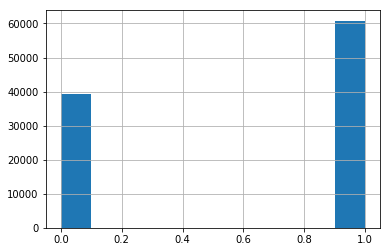

In [21]:
train.head(100000).NewEstimateTotal.hist()

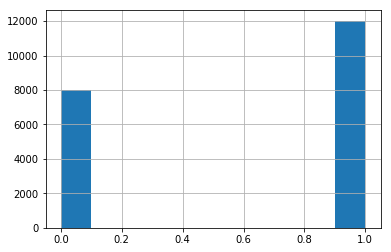

In [22]:
valid.head(20000).NewEstimateTotal.hist()

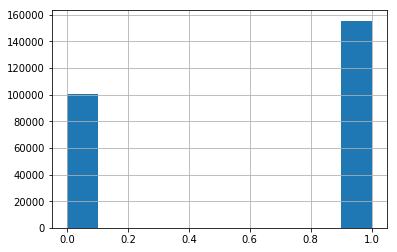

In [23]:
test.NewEstimateTotal.hist()